In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

import innvestigate
import innvestigate.utils as iutils


import os

/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages

1.13.1


In [104]:
# Show all numbers as float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

## Useful Functions

In [2]:
def build_XY(features,label,dic):
    X_test=[dic[key] for key in features]
    Y_test=[dic[key] for key in label]
    X_test[0]=X_test[0].reshape(n_test, grid, grid, 1)
    dim=[1 if ele[0].shape==() else ele[0].shape[0] for ele in X_test]
    for i in range(1,len(X_test)):
        X_test[i]=X_test[i].reshape(len(X_test[i]),dim[i])
    return X_test,Y_test

In [3]:
def find_flatten(model):
    for ii in range(len(model.layers)):
        conf=model.layers[ii].get_config()
        if conf['name'][:7]=='flatten':
            return ii

In [4]:
def Split_model(model):
    # Split model at Flatten Layer
    pos_flatten=find_flatten(model)
    conv_model=models.Model(model.input[0],model.layers[5].output)
    # Get output dimensions of Conv Model
    input_dim=conv_model.output_shape[-1]
    mylayers=[model.layers[ii] for ii in range(pos_flatten+1,len(model.layers))]
    input1 = [layers.Input(shape = (input_dim,))]
    # Check first dense layer is input layer for expert variables
    if mylayers[0].get_config()['name'][:5]!='input':
        return print('Error: Next Layer after Flatten is not input layer for Expert Variables')
    num_expert=0
    for lay in mylayers:
        conf=lay.get_config()
        if conf['name'][:5]=='input':
            input1+=[layers.Input(shape = (lay.input_shape[-1],))]
            num_expert+=1
        else:
            break
    # After Expert Variables we have a concatenate layer
    x = layers.concatenate(inputs = input1,axis=-1)
    for ii in range(num_expert+1,len(mylayers)):
        x = mylayers[ii](x)
    dense_model = models.Model(inputs=input1, outputs=x)
    dense_model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['binary_crossentropy', 'accuracy'])
    return conv_model,dense_model

In [6]:
def Get_LRP_Score(data,model,LRP_fct):
    # Strip model of softmax function for LRP
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    # Build LRP analyzer
    lrp_analyzer = innvestigate.create_analyzer(LRP_fct, model_ws)
    lrp_inb = [lrp_analyzer.analyze(ele) for ele in data]
    # Sum Picture and feature scores
    lrp_score=np.array([[np.sum(feature) for feature in ele] for ele in lrp_inb])
    return lrp_score

In [72]:
conv_model,dense_model=Split_model(best_model)

In [76]:
test=Get_LRP_Score(X_dense,dense_model,'lrp.z')

## Import data:
Using ShowJetsData_full.npz to build the CNN.

In [111]:
grid = 16
data_test= np.load('data/ShowJet_full_test.npz')

In [112]:
n_test=len(data_test['jetPt'])
print(n_test)

99270


In [116]:
feat_all=[key for key in data_test.keys()]
feat_all.remove('labels')

# Model with Image+ All Expert Variables

## Permutation Invariance

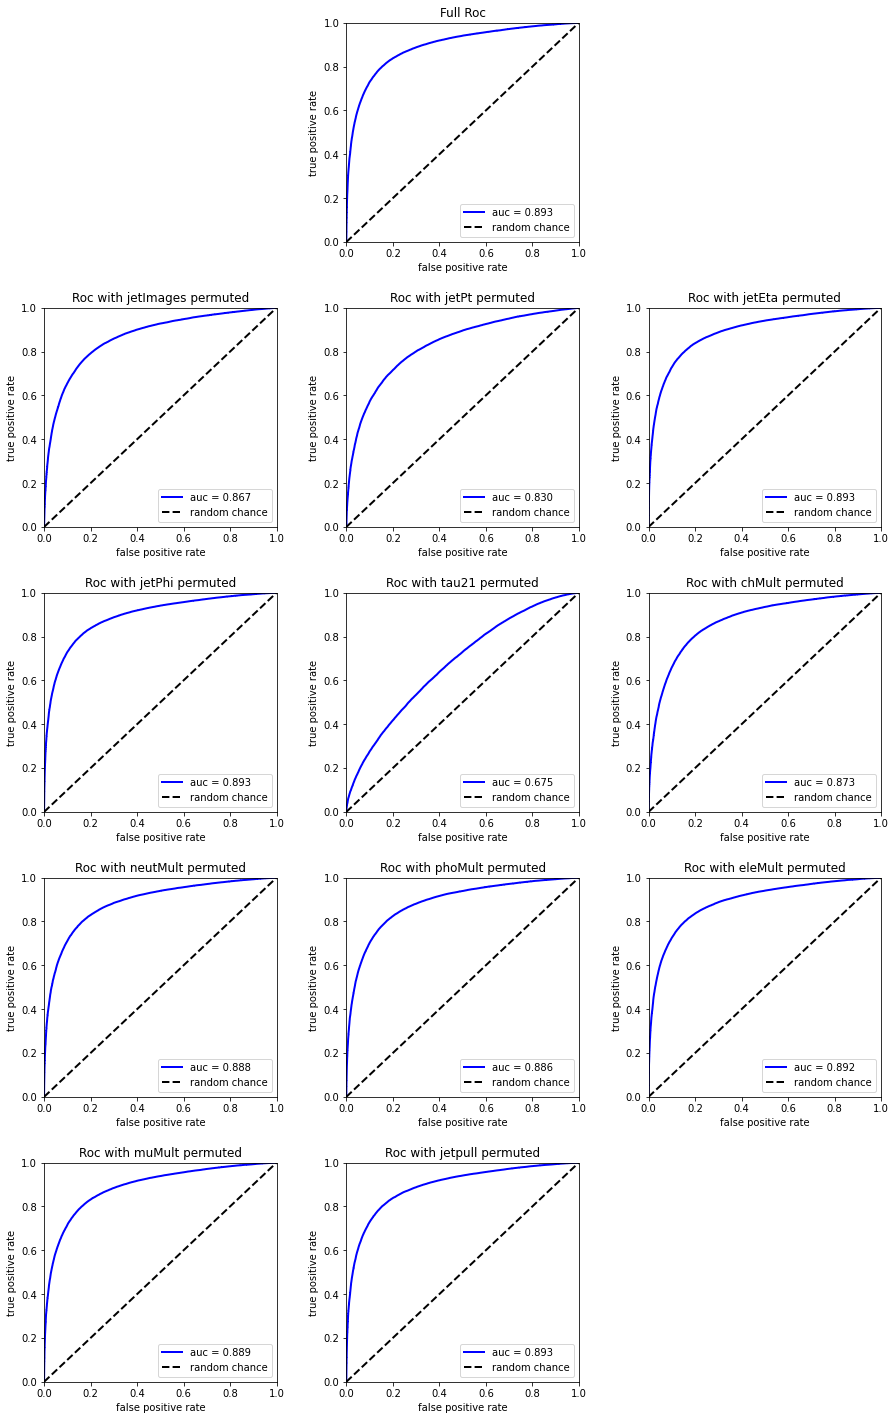

In [69]:
features=feat_all[:-1]
label=['labels']
X_test,Y_test=build_XY(features,label,data_test)
# Load Model
best_model = keras.models.load_model('model/CNN_all.h1')
# Build ROC curve for Unpermuted data, permutation of feature 0 and 1
fig = plt.figure(figsize=(15, 25))
fig_grid = plt.GridSpec(5, 3, wspace=0.3, hspace=0.3)
sub_p=[1 for j in range(len(features))]
for j in range(-1,len(features)):
#for j in range(-1,4):
    # Save Data in new list
    sub=[np.copy(ele) for ele in X_test]
    # permute feature j (j==-1 means leave unpermuted)
    if j>-1:
        np.random.shuffle(sub[j])
    # predict with new data
    predict= best_model.predict(sub)
    # Build ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
    roc_auc = auc(fpr, tpr)
    if j==-1:
        sub_p[j]=fig.add_subplot(fig_grid[0,1])
    else:
        row=int((j/3+1))
        col=(j%3)
        sub_p[j]=fig.add_subplot(fig_grid[row,col])
    sub_p[j].plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
    sub_p[j].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    sub_p[j].set_xlim([0, 1.0])
    sub_p[j].set_ylim([0, 1.0])
    sub_p[j].set_xlabel('false positive rate')
    sub_p[j].set_ylabel('true positive rate')
    if j==-1:
        sub_p[j].set_title('Full Roc')
    else:
        sub_p[j].set_title('Roc with '+features[j]+' permuted')
    sub_p[j].legend(loc="lower right")
    plt.savefig('plots/ROC_all.pdf')

## LRP

In [107]:
features=feat_all[:-1]
label=['labels']
X_test,Y_test=build_XY(features,label,data_test)
# Load Model
full_model = keras.models.load_model('model/CNN_all.h1')
# Split Model into Conv and Dense Layers
conv_model,dense_model=Split_model(full_model)
# Reshape Data, for easier application of LRP algorithm
X_lrp=[[X_test[i][j] for i in range(len(features))] for j in range(n_test)]
for i in range(n_test):
    X_lrp[i][0]=X_lrp[i][0].reshape(1,grid,grid,1)
# Build Data input for dense Layers
X_dense=[[conv_model.predict(X_lrp[i][0])]+X_lrp[i][1:] for i in range(n_test)]

In [108]:
# Get LRP score
LRP_full=Get_LRP_Score(X_lrp,full_model,"lrp.z")
LRP_dense=Get_LRP_Score(X_dense,dense_model,"lrp.z")
# Normalize LRP score with respect to prediction
dense_model_ws = iutils.keras.graph.model_wo_softmax(dense_model)
predict=[np.max(dense_model_ws.predict(X_dense[i]),axis=1) for i in range(n_test)]
for i in range(n_test):
    LRP_full[i]=LRP_full[i]/predict[i]
    LRP_dense[i]=LRP_dense[i]/predict[i]
# Print Results
print('Model with '+feat_all[ii])
print('Full Model: ',np.round(np.mean(LRP_full,axis=0),decimals=3))
print('Dense Model: ',np.round(np.mean(LRP_dense,axis=0),decimals=3))
print('')

Model with jetpull
Full Model:  [1.460000 0.389000 0.026000 0.006000 -0.400000 -0.313000 -0.142000
 -0.140000 -0.036000 0.217000 0.001000]
Dense Model:  [0.420000 0.389000 0.026000 0.006000 -0.400000 -0.313000 -0.142000
 -0.140000 -0.036000 0.217000 0.001000]



# Models with Image + 1 Expert Variable

## Permutation Invariance

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


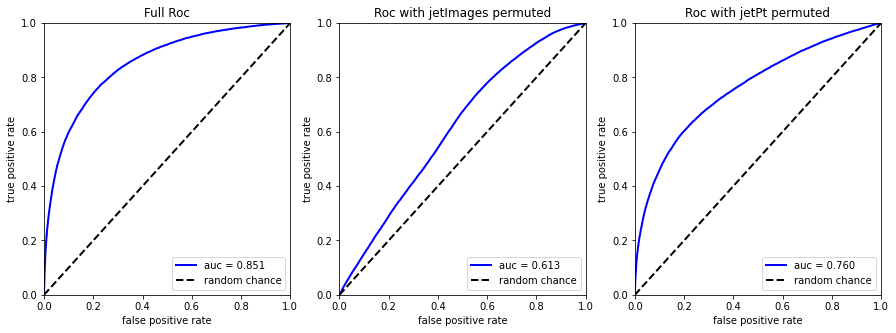

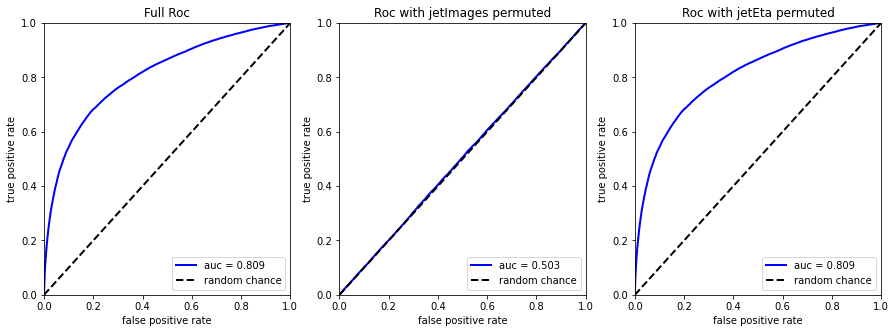

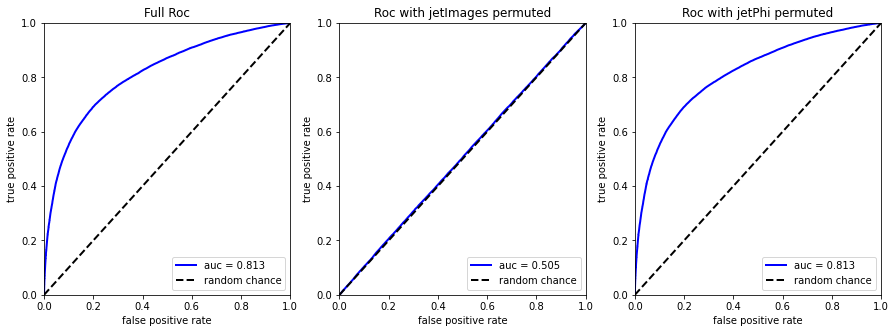

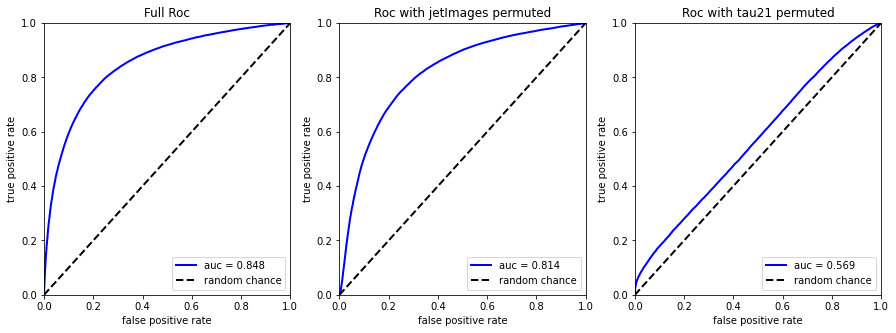

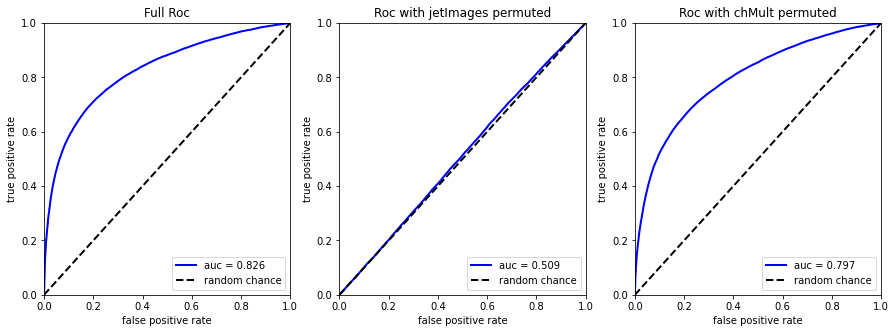

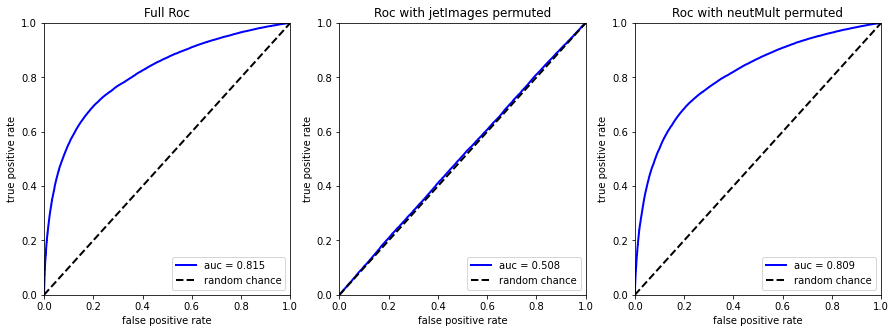

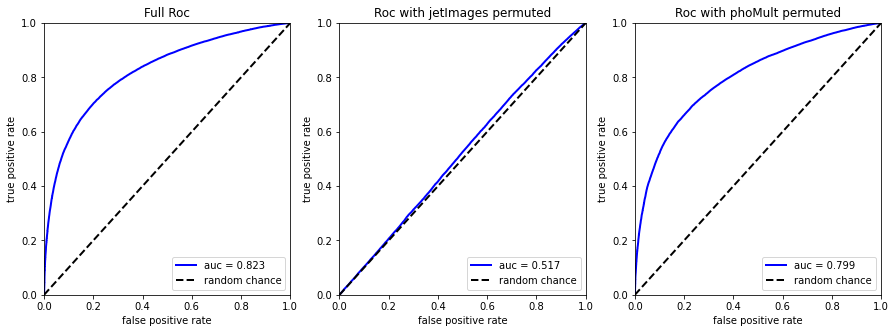

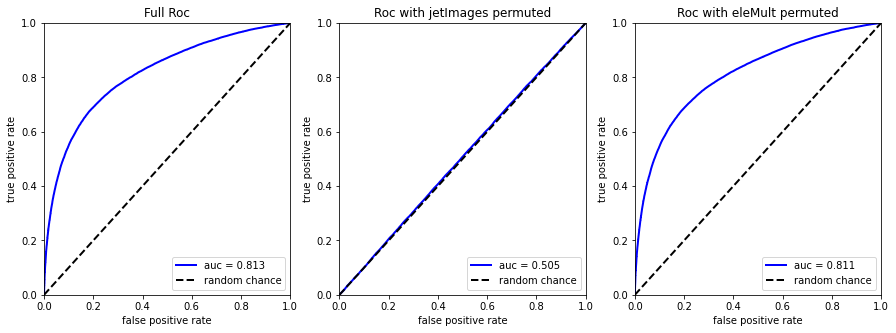

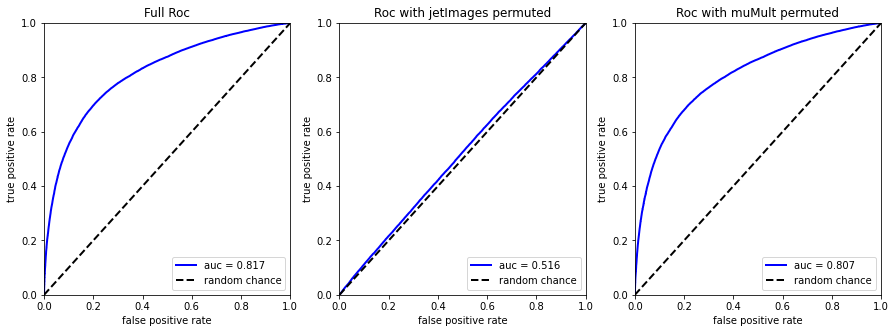

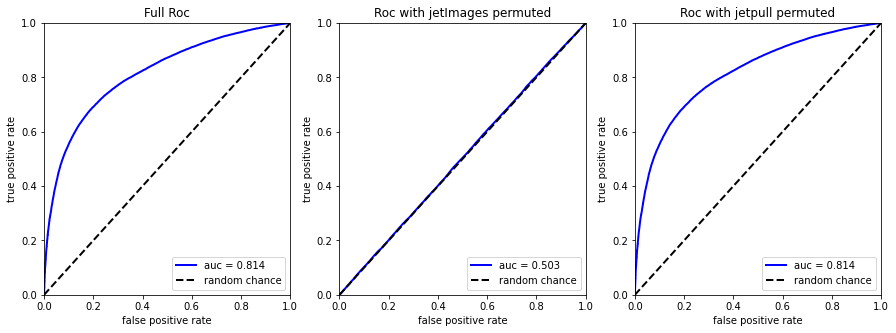

In [10]:
for ii in range(1,len(feat_all)-1):
    # Select features and build X_test and Y_test
    features=['jetImages']+[feat_all[ii]]
    label=['labels']
    X_test,Y_test=build_XY(features,label,data_test)
    # Load Model
    best_model = keras.models.load_model('model/CNN_sub_'+str(ii)+'.h1')
    # Build ROC curve for Unpermuted data, permutation of feature 0 and 1
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
    for j in range(-1,len(features)):
        # Save Data in new list
        sub=[np.copy(ele) for ele in X_test]
        # permute feature j (j==-1 means leave unpermuted)
        if j>-1:
            np.random.shuffle(sub[j])
        # predict with new data
        predict= best_model.predict(sub)
        # Build ROC curve
        fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
        roc_auc = auc(fpr, tpr)
        ax[j+1].plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
        ax[j+1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
        ax[j+1].set_xlim([0, 1.0])
        ax[j+1].set_ylim([0, 1.0])
        ax[j+1].set_xlabel('false positive rate')
        ax[j+1].set_ylabel('true positive rate')
        if j==-1:
            ax[j+1].set_title('Full Roc')
        else:
            ax[j+1].set_title('Roc with '+features[j]+' permuted')
        ax[j+1].legend(loc="lower right")
#    plt.savefig('plots/ROC_'+features[1]+'.pdf')

### For Abs jetpull
Done later again

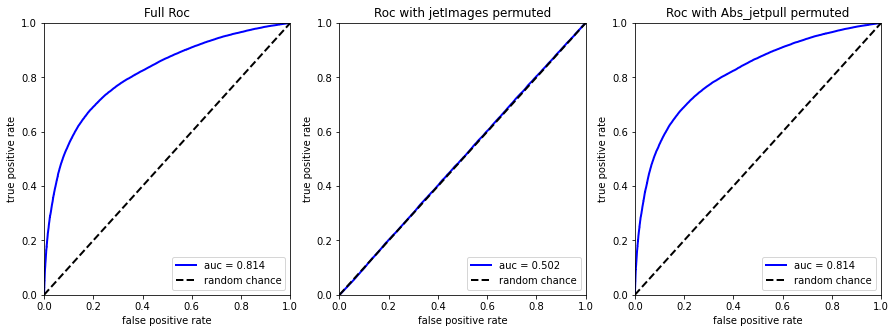

In [119]:
# Select features and build X_test and Y_test
features=['jetImages']+[feat_all[11]]
label=['labels']
X_test,Y_test=build_XY(features,label,data_test)
# Load Model
best_model = keras.models.load_model('model/CNN_sub_'+str(ii)+'.h1')
# Build ROC curve for Unpermuted data, permutation of feature 0 and 1
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
for j in range(-1,len(features)):
    # Save Data in new list
    sub=[np.copy(ele) for ele in X_test]
    # permute feature j (j==-1 means leave unpermuted)
    if j>-1:
        np.random.shuffle(sub[j])
    # predict with new data
    predict= best_model.predict(sub)
    # Build ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
    roc_auc = auc(fpr, tpr)
    ax[j+1].plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
    ax[j+1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax[j+1].set_xlim([0, 1.0])
    ax[j+1].set_ylim([0, 1.0])
    ax[j+1].set_xlabel('false positive rate')
    ax[j+1].set_ylabel('true positive rate')
    if j==-1:
        ax[j+1].set_title('Full Roc')
    else:
        ax[j+1].set_title('Roc with '+features[j]+' permuted')
    ax[j+1].legend(loc="lower right")
    plt.savefig('plots/ROC_'+features[1]+'.pdf')

## LRP

In [106]:
for ii in range(1,len(feat_all)-1):
    features=['jetImages']+[feat_all[ii]]
    label=['labels']
    X_test,Y_test=build_XY(features,label,data_test)
    # load Model
    full_model = keras.models.load_model('model/CNN_sub_'+str(ii)+'.h1')
    # Split Model into Conv and Dense Layers
    conv_model,dense_model=Split_model(full_model)
    # Reshape Data, for easier application of LRP algorithm
    X_lrp=[[X_test[i][j] for i in range(len(features))] for j in range(n_test)]
    for i in range(n_test):
        X_lrp[i][0]=X_lrp[i][0].reshape(1,grid,grid,1)
    # Build Data input for dense Layers
    X_dense=[[conv_model.predict(X_lrp[i][0])]+X_lrp[i][1:] for i in range(n_test)]
    # Get LRP score
    LRP_full=Get_LRP_Score(X_lrp,full_model,"lrp.z")
    LRP_dense=Get_LRP_Score(X_dense,dense_model,"lrp.z")
    # Normalize LRP score with respect to prediction
    dense_model_ws = iutils.keras.graph.model_wo_softmax(dense_model)
    predict=[np.max(dense_model_ws.predict(X_dense[i]),axis=1) for i in range(n_test)]
    for i in range(n_test):
        LRP_full[i]=LRP_full[i]/predict[i]
        LRP_dense[i]=LRP_dense[i]/predict[i]
    # Print Results
    print('Model with '+feat_all[ii])
    print('Full Model: ',np.round(np.mean(LRP_full,axis=0),decimals=3))
    print('Dense Model: ',np.round(np.mean(LRP_dense,axis=0),decimals=3))
    print('')

Model with jetPt
Full Model:  [2.830000 0.265000]
Dense Model:  [0.814000 0.265000]

Model with jetEta
Full Model:  [0.293000 0.024000]
Dense Model:  [0.868000 0.024000]

Model with jetPhi
Full Model:  [1.887000 0.008000]
Dense Model:  [-1.324000 0.008000]

Model with tau21
Full Model:  [-1.136000 6.751000]
Dense Model:  [1.205000 6.751000]

Model with chMult
Full Model:  [3.156000 -0.796000]
Dense Model:  [2.240000 -0.796000]

Model with neutMult
Full Model:  [-2.857000 0.068000]
Dense Model:  [1.049000 0.068000]

Model with phoMult
Full Model:  [0.599000 -0.271000]
Dense Model:  [1.018000 -0.271000]

Model with eleMult
Full Model:  [0.317000 -0.007000]
Dense Model:  [0.903000 -0.007000]

Model with muMult
Full Model:  [2.384000 0.018000]
Dense Model:  [1.043000 0.018000]

Model with jetpull
Full Model:  [-15.225000 -0.004000]
Dense Model:  [0.834000 -0.004000]

